In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee

# The Gelman-Rubin statistic and `emcee`

In this post, I'll give a simple demo of using the Gelman-Rubin statistic to quantify convergance when using the `emcee` software package. The initial setup of the problem follows [this post](http://ga7g08.github.io/2015/01/20/Searching-for-signals-in-noise/) with some minor modifications.

## Data
First, we generate some fake data to which we will fit a model;

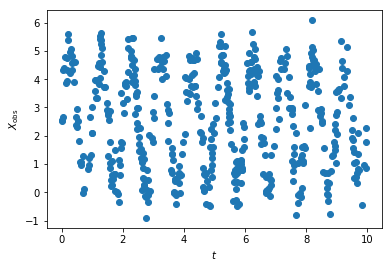

In [94]:
# Model parameters
A = 2.3
f = 1
X0 = 2.5

# Noise parameter
sigma = 0.6

N = 500
t = np.sort(np.random.uniform(0, 10, N))
X = X0 + A * np.sin(2 * np.pi * f * t) + np.random.normal(0, sigma, N)

plt.plot(t, X, "o")
plt.xlabel("$t$")
plt.ylabel(r"$X_{\mathrm{obs}}$")
plt.show()

## Set-up for using `emcee`

### Define some generic helper functions

In [ ]:
def Generic_lnuniformprior(theta, theta_lims):
    """ Generic uniform priors on theta 
    
    Parameters
    ----------
    theta : array_like 
        Value of the parameters
    theta_lims: array_like of shape (len(theta), 2)
        Array of pairs [min, max] for each theta paramater
        
    """
    
    theta_lims = np.array(theta_lims)
    
    if all(theta - theta_lims[:, 0] > 0 ) and all(theta_lims[:, 1] - theta > 0):
        return np.prod(1.0/np.diff(theta_lims, axis=1))
    return -np.inf

def Generic_lnlike(theta, t, x, model):
    """ Generic likelihood function for signal in Gaussian noise
    
    Parameters
    ----------
    theta : array_like
        Value of the parameters, the noise strength `sigma` should ALWAYS be
        the last element in the list
    t : array_like
        The independant variable
    x : array_like
        The observed dependent variable
    model : func
        Signal model, calling `model(theta[:-1], t)` should
        produced the corresponding value of the signal 
        alone `x_val`, without noise. 
    
    """
    
    sigma2 = theta[-1]**2
    return -0.5*(np.sum((x-model(theta[:-1], t))**2 / sigma2 + np.log(2*np.pi*sigma2)))   
    
def PlotWalkers(sampler, symbols=None, alpha=0.4, color="k", PSRF=None, PSRFx=None):
    """ Plot all the chains from a sampler """
    nwalkers, nsteps, ndim = sampler.chain.shape
    PSRF = np.array(PSRF)
    fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 9))

    for i in range(ndim):
        axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=alpha)
        if symbols:
            axes[i].set_ylabel(symbols[i])
        if PSRF is not None:
            ax = axes[i].twinx()
            ax.plot(PSRFx, PSRF[:, i], '-r')

### Define model and uniform prior

In [112]:
def model(theta, t):
    A, f, X0 = theta 
    return X0 + A * np.sin(2 * np.pi * f * t)
    
lnlike = lambda theta, x, y: Generic_lnlike(theta, x, y, model)       

# Tie the two together
def lnprob(theta, x, y):
    """ Generic function ties together the lnprior and lnlike """ 
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)
            
# Prior
theta_lims = [[-10, 20], 
              [0.95, 1.05], 
              [0.0, 100.0],
              [0.1, 1.3]
              ]
lnprior = lambda theta: Generic_lnuniformprior(theta, theta_lims) 

## Calculating the PSRF

Here, I follow the description on [this blog](http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/) for how to calculate the Potential Scale Reduction Factor (PSRF), a measure of the converegance. For PSRF < 1.2, Gelam & Rubin state the the chains have converged.

In practical terms, the sampler is run for `dn` steps, PSRF is calculated, and then the sampler as run again. Here I simply plot how this changes for each parameter. This becomes practically useful when some measuure of the convergence (say for example the maximum PSRF) is used to end a run prematurely (before the maximum number of steps). 

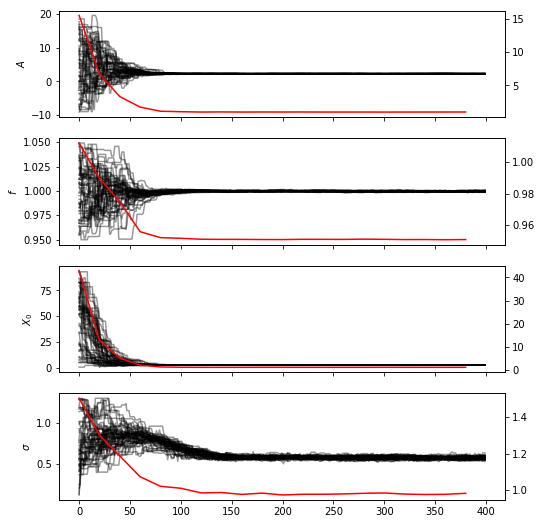

In [118]:
ndim = 4
nwalkers = 50
nsteps = 400
# Initialise the walkers
walker_pos = [[np.random.uniform(tl[0], tl[1]) for tl in theta_lims] 
                                                        for i in range(nwalkers)] 

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t, X))
dn = 20
ns = 0

PSRF = []
PSRFx = []
while ns < nsteps:
    walker_pos, _, _ = sampler.run_mcmc(walker_pos, dn)
    
    s = sampler.chain[:, -dn:, :]
    per_chain_mean = np.mean(s, axis=1)
    per_chain_std = np.std(s, axis=1)
    mean = np.mean(per_chain_mean, axis=0)
    B = dn / (nwalkers - 1.) * np.sum((per_chain_mean - mean)**2, axis=0)
    W = np.mean(per_chain_std, axis=0)
    Vhat = (dn-1.)/dn * W + (nwalkers+1.)/(nwalkers*dn)*B
    PSRF.append(Vhat / W)
    PSRFx.append(ns)
    ns += dn
  
symbols = ["$A$", "$f$", "$X_{0}$", "$\sigma$"]            
PlotWalkers(sampler, symbols=symbols, PSRF=PSRF, PSRFx=PSRFx)
plt.show()